# Sample portfolio 1

This notebook runs through the library on the one of the examples in the __'sample_portfolio2'__

At the end we optimize to get the results of all the 8 different views

First we import everything

In [1]:
import pandas as pd 
import numpy as np
from entropy_pooling import views
from entropy_pooling import entropy_minimizer
from entropy_pooling import markoviz_optimizer

Then we get the data

In [2]:
data_raw = pd.read_excel("data/data.xlsx").dropna(axis=1, how='all')
weights = data_raw[["Weight"]]
scenarios = data_raw.drop(columns = ["Weight"])/100

We load the vies

In [3]:
(A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx",
                       views_subsheet_name = 2);

We create the posterior distribution

In [4]:
c = 1
p = np.array(weights)
m,n = p.shape

posterior = entropy_minimizer.full_confidence_posterior(p, A, b, C, d, verbose = True)
weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)



Results
Optimal dual variable values:  [ 1.74810296 -0.98789023]
Jacobian matrix at optimum [-2.44324742e-07 -2.34828439e-08]


We get the deltas and create the asset space. Additionally, we import the additional constraints for the markoviz optimization.

We manually define to size of funds that can be used

In [5]:
total = 417000000

deltas, asset_names = markoviz_optimizer.load_asset_deltas("data/sample_portfolio2_deltas.xlsx")

asset_scenarios = markoviz_optimizer.asset_scenarios(scenarios, deltas, asset_names)

loaded_constraints = pd.read_excel("data/sample_portfolio2_constrs.xlsx").dropna(axis=1, how='all')
manual_constraints = (loaded_constraints.iloc[:,:-2],
                      loaded_constraints.iloc[:,-2],
                      loaded_constraints.iloc[:,-1])

And finally we do markowitz optimization on the posterior distribution and plot the outcome.

We minimize the volatility at return $\mu_0 = 0.5$ and do not allow for shorting.

The optimization was succesful: True
Global Equities: 5716160.0
DM Equities: 5716162.0
EM Equities: 5716141.0
European Equities: 5716160.0
US Equities: 5716164.0
EUR Money Markets: 54510410.0
EUR Government Bonds: 89363407.0
EUR Covered Bonds: 54510396.0
EUR Investment Grade Corporate Bonds: 54510383.0
European High Yield Corporate Bonds: 41699525.0
EMD Hard Currency: 54510363.0
Hedge Funds: 19657410.0
Listed Private Equity: 19657319.0
Technical Provisions: 1.0
IR Hedges: 1.0


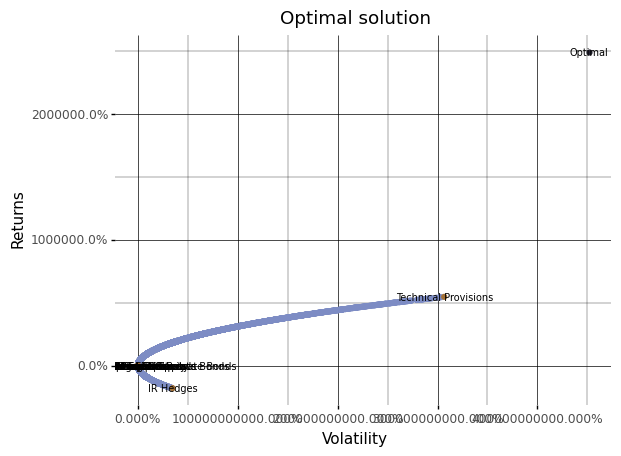

In [15]:
optimal_x = markoviz_optimizer.optimizer(asset_scenarios,
                                         weighted_posterior,
                                         mu_0 = 0,
                                         manual_constraints = manual_constraints,
                                         visualize = True,
                                         verbose = 1).x
for i, col in enumerate(asset_scenarios.columns):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

We can compare the optimization of the posterior distribution with the prior below

In [8]:
optimal_x = markoviz_optimizer.optimizer(asset_scenarios,
                                         weights,
                                         mu_0 = 0.01*total,
                                         manual_constraints = manual_constraints,
                                         visualize = True,
                                         verbose = 1).x

for i, col in enumerate(asset_scenarios.columns):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

The optimization was succesful: False
The optimization was terminated due to: 
Positive directional derivative for linesearch


KeyboardInterrupt: 

In [13]:
result = pd.DataFrame(columns = range(8), index =['Result','Optimal risk', 'Expected return', *asset_names])
weights_pos = pd.DataFrame(columns = range(8))
for i in range(8):
  (A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx", views_subsheet_name = i);
  c = 1                 #scenario probability
  p = np.array(weights)
  m,n = p.shape

  posterior = entropy_minimizer.full_confidence_posterior(p, A,b,C,d)
  weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)
  weights_pos.iloc[:,i] = weighted_posterior
  optimal = markoviz_optimizer.optimizer(asset_scenarios,
                                         weighted_posterior,
                                         mu_0 = 0,
                                         manual_constraints = manual_constraints,
                                         visualize = False,
                                         verbose = 0)
  probabilities_reshaped = np.asarray(weighted_posterior).reshape(-1,)
  mu = np.average(asset_scenarios, axis=0, weights = probabilities_reshaped)
  result.iloc[0,i] = optimal.success
  result.iloc[1,i] = np.round(optimal.fun, decimals= 0)
  result.iloc[2,i] = np.round(optimal.x @ mu, decimals= 0)
  result.iloc[3:,i] = np.round(optimal.x, decimals= 0)
result
  

,0,1,2,3,4,5,6,7
Result,True,False,True,True,True,True,True,True
Optimal risk,66126.0,1606.0,63985.0,76846.0,70081.0,64300.0,71405.0,67193.0
Expected return,11494.0,-2810.0,21617.0,9727.0,21699.0,23597.0,17383.0,24912.0
Global Equities,9581279.0,0.0,4955649.0,9969820.0,8891408.0,10395676.0,4880311.0,5716160.0
DM Equities,11165513.0,0.0,6505278.0,13443081.0,10070115.0,11494564.0,5000603.0,5716162.0
EM Equities,0.0,0.0,40293.0,63256.0,0.0,-0.0,21270797.0,5716141.0
European Equities,0.0,0.0,1565322.0,-0.0,4609437.0,-0.0,3391532.0,5716160.0
US Equities,20951339.0,0.0,14650769.0,18223843.0,15389327.0,19610053.0,5292811.0,5716164.0
EUR Money Markets,52125266.0,0.0,54103911.0,50487155.0,55087091.0,52145631.0,55947975.0,54510410.0
EUR Government Bonds,83401396.0,0.0,93068886.0,90199615.0,85636422.0,83522651.0,89905141.0,89363407.0


In [62]:
from plotnine import ggplot, geom_area, aes, scale_y_continuous

(A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx",
                       views_subsheet_name = 2);
precision = 4
result = pd.DataFrame(columns = range(precision), index =['Result','Optimal risk', 'Expected return', *asset_names])
for i in range(precision):
  c = 1                 #scenario probability
  p = np.array(weights)
  m,n = p.shape

  posterior = entropy_minimizer.full_confidence_posterior(p, A,b,C,d)
  weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)
  optimal = markoviz_optimizer.optimizer(asset_scenarios,
                                         weighted_posterior,
                                         mu_0 = i*(0.00001*2)*total,
                                         manual_constraints = manual_constraints,
                                         visualize = False,
                                         verbose = 0)
  probabilities_reshaped = np.asarray(weighted_posterior).reshape(-1,)
  mu = np.average(asset_scenarios, axis=0, weights = probabilities_reshaped)
  result.iloc[0,i] = optimal.success
  if optimal.success:
    result.iloc[1,i] = np.round(optimal.fun, decimals= 0)
    result.iloc[2,i] = np.round(optimal.x @ mu, decimals= 0)
    result.iloc[3:,i] = np.round(optimal.x, decimals= 0)
  else:
    result.iloc[1,i] = 0
    result.iloc[2,i] = 0
    result.iloc[3:,i] = np.zeros_like(result.iloc[3:,i])

melted= result.iloc[3:,:].melt(ignore_index=False).reset_index()


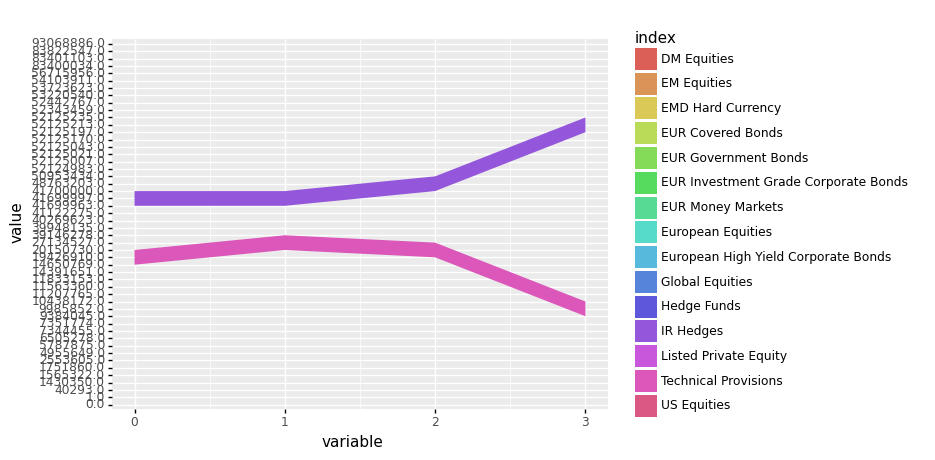

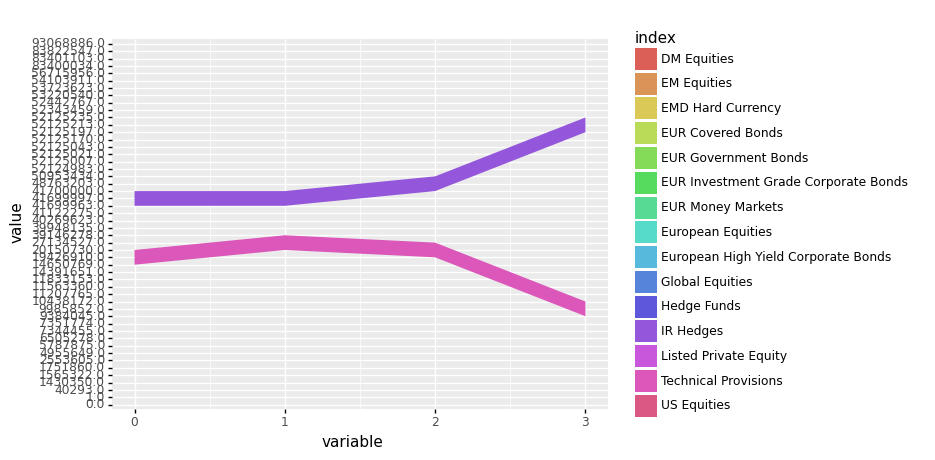

In [63]:
plot = (ggplot(data = melted, mapping =  aes( x='variable', fill='index', y='value')) 
        + geom_area())
plot.draw()

In [64]:
result

,0,1,2,3
Result,True,True,True,True
Optimal risk,63985.0,64823.0,65058.0,72675.0
Expected return,21617.0,22428.0,22518.0,25020.0
Global Equities,4955649.0,9985852.0,10438172.0,7344455.0
DM Equities,6505278.0,11563360.0,11833153.0,7351774.0
EM Equities,40293.0,-0.0,0.0,11207765.0
European Equities,1565322.0,-0.0,0.0,5787875.0
US Equities,14650769.0,20150730.0,19426910.0,9384045.0
EUR Money Markets,54103911.0,52125043.0,52125235.0,48763203.0
EUR Government Bonds,93068886.0,83400034.0,83401103.0,83822547.0
